In [1]:
import os
import json
import pandas as pd
import numpy as np
import random
import shutil
import torch
import seaborn as sn
import pandas as pd
import copy
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from PIL import Image
from pathlib import Path
from torch import nn
from typing import List
from sklearn.metrics import confusion_matrix

In [2]:
# Hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = 8
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4

# Dataloader

In [3]:
# Reference: https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Setup train and testing paths
train_dir = './dataset_grouped/train'
val_dir = './dataset_grouped/valid'
test_dir = './dataset_grouped/test'

In [6]:
# Run this for training from scratch
def get_mean_std(dataset_path):
    # Load your dataset
    dataset = datasets.ImageFolder(root=dataset_path, transform=transforms.ToTensor())

    # Calculate mean and std
    mean = torch.zeros(3) 
    std = torch.zeros(3)

    for images, _ in dataset:
        mean += torch.tensor([images[0].mean(), images[1].mean(), images[2].mean()])
        std += torch.tensor([images[0].std(), images[1].std(), images[2].std()])

    mean /= len(dataset)
    std /= len(dataset)

    return mean, std

train_mean, train_std = get_mean_std(train_dir)


In [8]:
# Run this for ImageNet transfer learning
train_mean = [0.485, 0.456, 0.406]
train_std = [0.229, 0.224, 0.225]

In [7]:
# Write transform for image
train_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

val_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std)
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_data_transform)

val_data = datasets.ImageFolder(root=val_dir,
                                  transform=val_data_transform)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=test_data_transform)

In [8]:
class_dict = train_data.class_to_idx
class_names = train_data.classes

In [9]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset, mean, std, classes, n=10, display_shape=True, seed=None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(20, 10))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Unnormalize for showing image
        unnormalize = transforms.Normalize(mean=[-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]], std=[1 / std[0], 1 / std[1], 1 / std[2]])
        targ_image = unnormalize(targ_image)

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

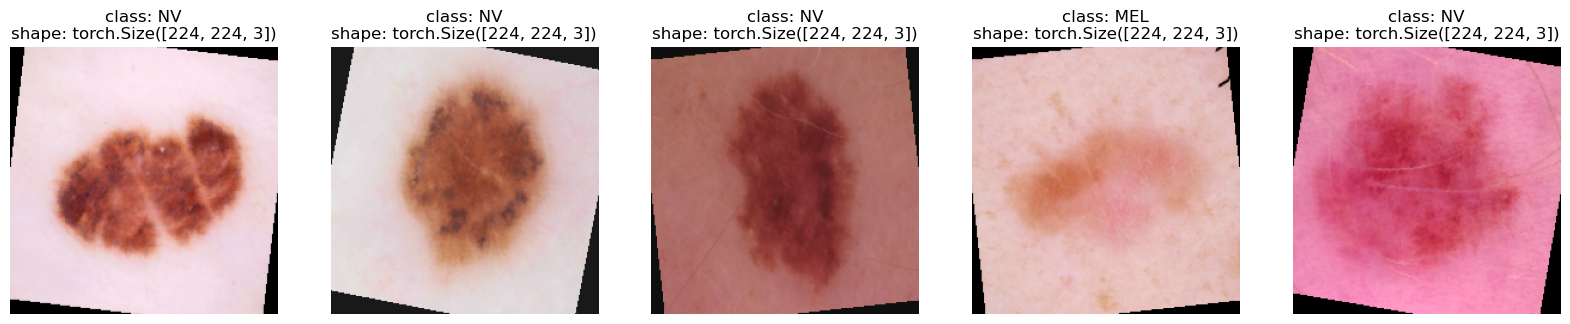

In [10]:
# Display random images from Dataset
display_random_images(train_data,
                      mean=train_mean,
                      std=train_std, 
                      n=5, 
                      classes=class_names,
                      seed=None)

In [11]:
# Weighted Random Sampler
df_train = pd.read_csv('./ISIC2018_Task3_Training_GroundTruth.csv')
class_counts = []
for name in class_names:
    class_counts.append(df_train[name].value_counts()[1])

# Calculating weights for each class
weights = 1. / np.array(class_counts)

# Assign weights based on their classes
samples_weight = np.array([weights[t] for t in train_data.targets])
samples_weight = torch.from_numpy(samples_weight)

# Weighted Random Sampler
sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [12]:
# Turn Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE,
                              sampler=sampler,
                              num_workers=NUM_WORKERS)

val_dataloader = DataLoader(dataset=val_data, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False,
                             num_workers=NUM_WORKERS)

# ResNet18 / 34 (From scratch)

In [13]:
# Reference: https://www.kaggle.com/code/muhammedtuncayaydn/implementing-resnet-18-and-resnet-34-in-pytorch/notebook

In [14]:
class BasicBlock(nn.Module):
    expansion=1
    
    def __init__(self,in_planes,planes,stride):
        super(BasicBlock,self).__init__()
        
        self.conv1=nn.Conv2d(in_planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(planes)
        self.conv2=nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(planes)
        
        self.shortcut=nn.Sequential()
        if((stride!=1)or(in_planes!=self.expansion*planes)):
            self.shortcut=nn.Sequential(nn.Conv2d(in_planes,self.expansion*planes,kernel_size=1,stride=stride,bias=False), nn.BatchNorm2d(self.expansion*planes))
            
    def forward(self,x):
        out=self.conv1(x)
        out=self.bn1(out)
        out=nn.ReLU()(out)
        
        out=self.conv2(out)
        out=self.bn2(out)
        out=out+self.shortcut(x)
        out=nn.ReLU()(out)
        
        return out  

In [15]:
class ResNet(nn.Module):
    
    def __init__(self,block,num_blocks,num_classes=7):
        super(ResNet,self).__init__()
        
        self.in_planes=64
        self.conv1=nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        
        self.layer1=self._make_layer(block,64,num_blocks[0],stride=1)
        self.layer2=self._make_layer(block,128,num_blocks[1],stride=2)
        self.layer3=self._make_layer(block,256,num_blocks[2],stride=2)
        self.layer4=self._make_layer(block,512,num_blocks[3],stride=2)
        
        self.avgpool=nn.AdaptiveAvgPool2d((1,1))
        self.fc=nn.Linear(512*block.expansion,num_classes)
        
    def _make_layer(self,block,planes,num_blocks,stride):
        strides=[stride]+[1]*(num_blocks-1)
        layers=[]
        
        for stride in strides:
            layers.append(block(self.in_planes,planes,stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

In [16]:
model = ResNet18()

#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11180103

In [18]:
import torchinfo
from torchinfo import summary

summary(model, input_size=[32, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 7]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─Conv2d: 3-3                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-4             [32, 64, 56, 56]          128
│    │    └─Sequential: 3-5              [32, 64, 56, 56]          --
│    └─BasicBlock: 2-2                   [32, 64, 56, 56]          --
│

# ResNet 18 / 34 / 50 / 101 (Transfer Learning)

In [13]:
from torchvision.models import resnet34
from torchvision.models import ResNet34_Weights

# Load the resnet18 network *pre-trained* on the ImageNet dataset
# weights = ResNet34_Weights.DEFAULT
res_model = resnet34()

In [15]:
# Freeze base model
# res_model.requires_grad_(False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
N_CLASSES = 7

model = nn.Sequential(
    res_model,
    nn.Linear(1000, 512),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

In [15]:
#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

22313775

In [16]:
import torchinfo
from torchinfo import summary

summary(model, input_size=[32, 3, 224, 224])

Layer (type:depth-idx)                        Output Shape              Param #
Sequential                                    [32, 7]                   --
├─ResNet: 1-1                                 [32, 1000]                --
│    └─Conv2d: 2-1                            [32, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                       [32, 64, 112, 112]        128
│    └─ReLU: 2-3                              [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                         [32, 64, 56, 56]          --
│    └─Sequential: 2-5                        [32, 64, 56, 56]          --
│    │    └─BasicBlock: 3-1                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-2                   [32, 64, 56, 56]          73,984
│    │    └─BasicBlock: 3-3                   [32, 64, 56, 56]          73,984
│    └─Sequential: 2-6                        [32, 128, 28, 28]         --
│    │    └─BasicBlock: 3-4                   [32, 128, 28, 28]         230,144

# Training the model

In [19]:
def train_val_step(model, train_dataloader, val_dataloader, loss_fn, optimizer):
    
    # Setup loss and accuracy values
    train_loss, train_acc = 0, 0
    val_loss, val_acc = 0, 0
    
    # Put model in train mode
    model.train()
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(train_dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # Forward Pass
        y_pred = model(X)

        # Calculate Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Put model in eval mode
    model.eval() 

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(val_dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            val_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(val_pred, y)
            val_loss += loss.item()
            
            # Calculate and accumulate accuracy
            val_pred_class = torch.argmax(torch.softmax(val_pred, dim=1), dim=1)
            val_acc += (val_pred_class == y).sum().item()/len(val_pred_class)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    val_loss = val_loss / len(val_dataloader)
    val_acc = val_acc / len(val_dataloader)

    return train_loss, train_acc, val_loss, val_acc

In [20]:
def test_step(model, test_dataloader, loss_fn):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(test_dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(test_dataloader)
    test_acc = test_acc / len(test_dataloader)
    return test_loss, test_acc

In [21]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          val_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          patience: int = 20,
          start_from_epoch: int = 20,
          epochs: int = 5):
    
    # Early stopper
    best_loss = float('inf')
    best_epoch = None
    best_model_weights = None
    patience_copy = patience

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Loop through training and testing steps for a number of epochs
    for epoch in range(epochs):
        train_loss, train_acc, val_loss, val_acc = train_val_step(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn, optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, test_dataloader=test_dataloader, loss_fn=loss_fn)
        
        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} | "
            f"val_acc: {val_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["val_loss"].append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)
        results["val_acc"].append(val_acc.item() if isinstance(val_acc, torch.Tensor) else val_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
        
        # Early stopper
        if epoch+1 > start_from_epoch:
            if val_loss < best_loss:
                best_loss = val_loss
                best_epoch = epoch+1
                best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here      
                patience_copy = patience  # Reset patience counter
            else:
                patience_copy -= 1
                if patience_copy == 0:
                    print(f'Early stopping! Saving best model at epoch {best_epoch}')
                    break
    
    # Return the filled results
    print(f'Done Training! Saving best model at epoch {best_epoch}')
    return results, best_model_weights

In [22]:
# Send model to device
model = model.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Train model
model_results, best_model = train(model=model, 
                                train_dataloader=train_dataloader,
                                val_dataloader=val_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn, 
                                patience = 20,
                                start_from_epoch = 20,
                                epochs=NUM_EPOCHS)

Epoch: 1 | train_loss: 1.5203 | train_acc: 0.4064 | val_loss: 1.1408 | val_acc: 0.4955 | test_loss: 1.2737 | test_acc: 0.4850
Epoch: 2 | train_loss: 1.2141 | train_acc: 0.5279 | val_loss: 0.8846 | val_acc: 0.6830 | test_loss: 1.1798 | test_acc: 0.5638
Epoch: 3 | train_loss: 1.0925 | train_acc: 0.5778 | val_loss: 0.9081 | val_acc: 0.6696 | test_loss: 1.1843 | test_acc: 0.5423
Epoch: 4 | train_loss: 0.9860 | train_acc: 0.6230 | val_loss: 1.1473 | val_acc: 0.6295 | test_loss: 1.5946 | test_acc: 0.4668
Epoch: 5 | train_loss: 0.8908 | train_acc: 0.6543 | val_loss: 0.8187 | val_acc: 0.6964 | test_loss: 1.0503 | test_acc: 0.6068
Epoch: 6 | train_loss: 0.8235 | train_acc: 0.6831 | val_loss: 1.2838 | val_acc: 0.5223 | test_loss: 1.3858 | test_acc: 0.5215
Epoch: 7 | train_loss: 0.7874 | train_acc: 0.6925 | val_loss: 0.8580 | val_acc: 0.6830 | test_loss: 1.1023 | test_acc: 0.5801
Epoch: 8 | train_loss: 0.7153 | train_acc: 0.7279 | val_loss: 0.7336 | val_acc: 0.7188 | test_loss: 0.9989 | test_acc:

# Plotting graphs from results

In [23]:
def plot_loss_curves(results):
    # Get the loss values of the results dictionary (training and test)
    train_loss = results['train_loss']
    val_loss = results['val_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    train_acc = results['train_acc']
    val_acc = results['val_acc']
    test_acc = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(25, 25))

    # Plot train and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, label='train_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_acc, label='train_accuracy')
    plt.plot(epochs, val_acc, label='val_accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot test loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Test Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, test_acc, label='test_accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

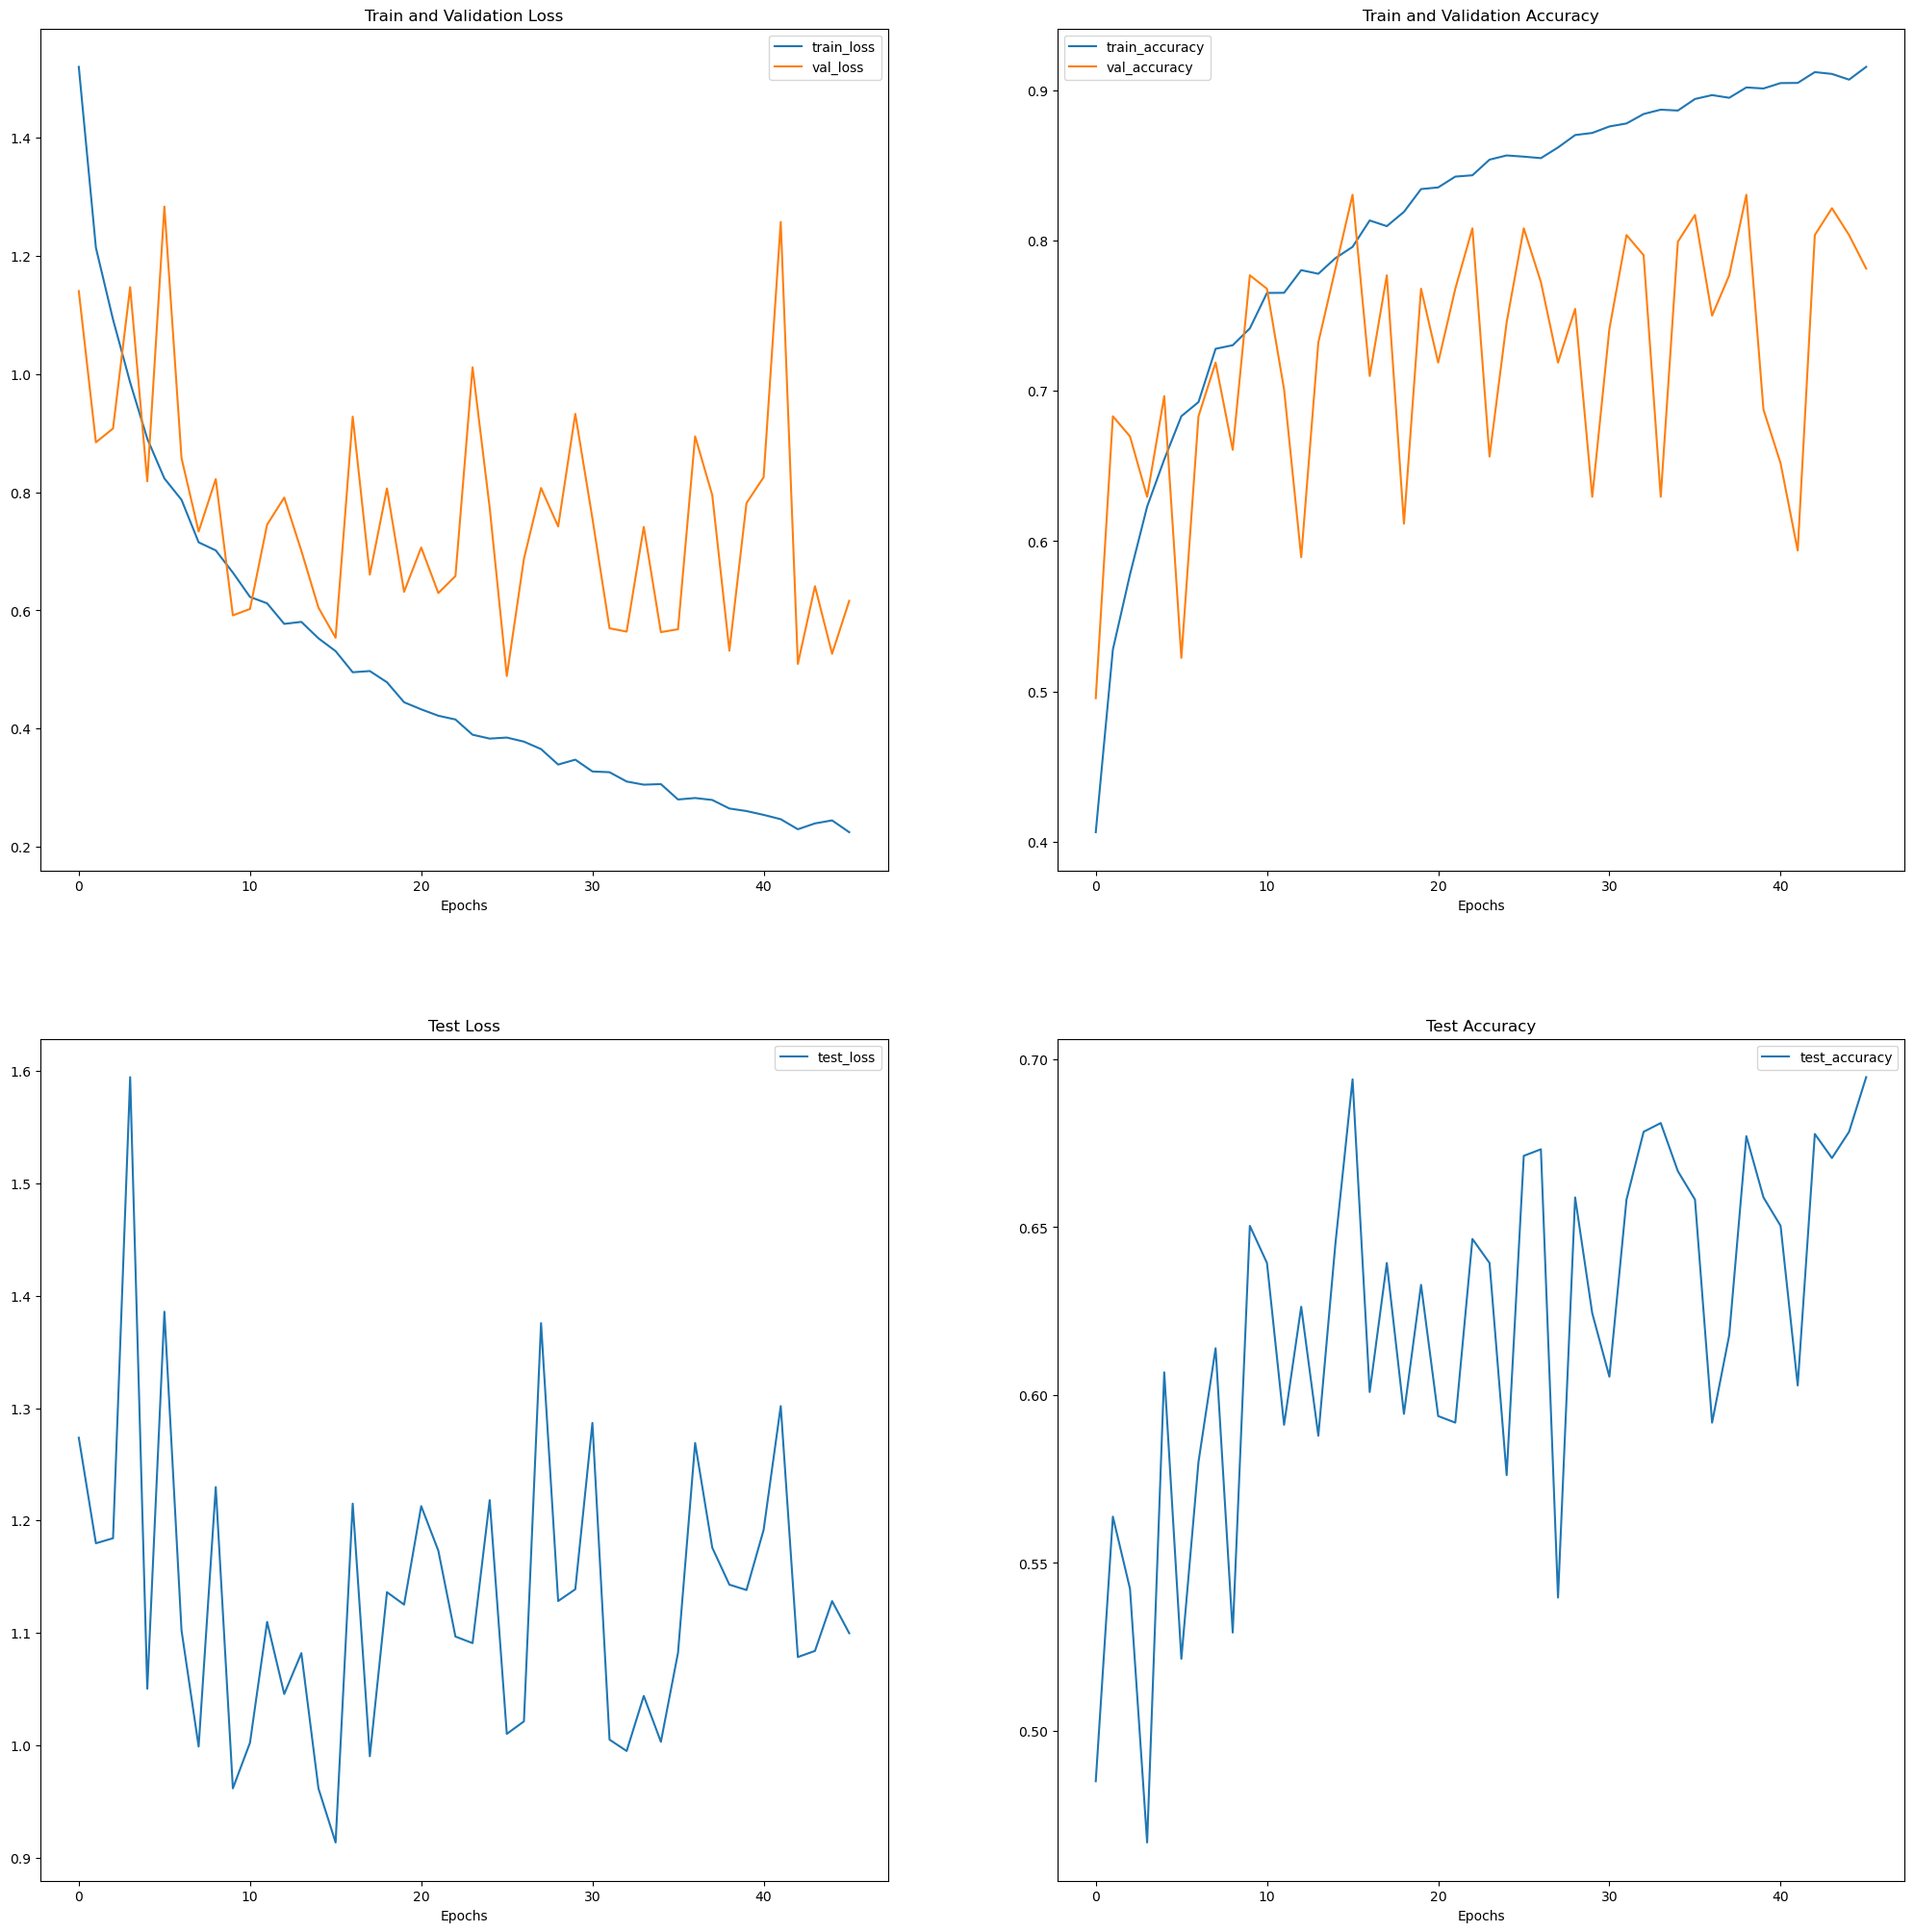

In [24]:
plot_loss_curves(model_results)
plt.savefig('results/graph/resnet18_sgd_scratch.png')

# Unfreeze and Fine-Tuning

In [23]:
# Unfreeze the base model
model.load_state_dict(best_model)
model.requires_grad_(True)
optimizer = torch.optim.SGD(model.parameters(), lr=.000001, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

In [24]:
# Full fine-tuning
epochs = 2

for epoch in range(epochs):
    train_loss, train_acc, val_loss, val_acc = train_val_step(model=model,
                                                            train_dataloader=train_dataloader,
                                                            val_dataloader=val_dataloader,
                                                            optimizer=optimizer,
                                                            loss_fn=loss_fn)
                                                            
          
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"val_loss: {val_loss:.4f} | "
        f"val_acc: {val_acc:.4f}"
        )

Epoch: 1 | train_loss: 0.5230 | train_acc: 0.8084 | val_loss: 0.6525 | val_acc: 0.7411
Epoch: 2 | train_loss: 0.5365 | train_acc: 0.8017 | val_loss: 0.6188 | val_acc: 0.7679


# Testing Model

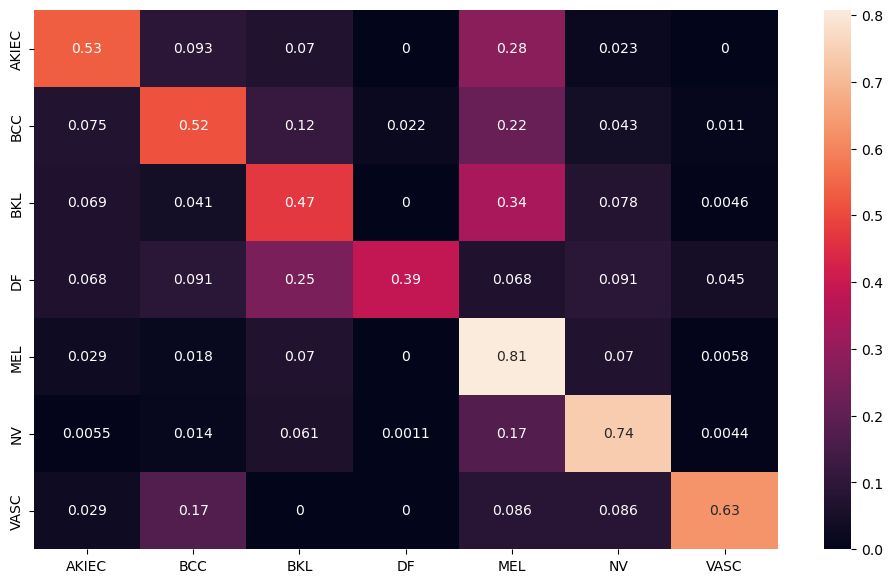

In [25]:
# Reference: https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
# Confusion matrix
y_pred = []
y_true = []

# Put model in eval mode
model.load_state_dict(best_model)
model = model.to(device) 
model.eval() 

# Turn on inference context manager
with torch.inference_mode():
# iterate over test data
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        output = model(X) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = y.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('results/confusion_matrix/resnet18_sgd_scratch.png')

In [26]:
# For testing best model
final_loss, final_acc = test_step(model, test_dataloader, loss_fn)
print(f'Best model performance - Test Loss: {final_loss:.4f} - Test Accuracy: {final_acc:.4f}')

Best model performance - Test Loss: 1.0102 - Test Accuracy: 0.6712


In [29]:
# Test a random image
img_path = 'dataset_grouped/test/NV/ISIC_0034524.jpg'
img = Image.open(img_path)

img_transformed = test_data_transform(img)
img_transformed  = img_transformed.to(device)
img_transformed = img_transformed.unsqueeze(0) # Add batch dimension
predicted = model(img_transformed)

print(f'Predicted class: {class_names[predicted.argmax()]}')

Predicted class: NV


# Save and reset your model

In [27]:
# Save the best model
torch.save(best_model, 'models/resnet18_sgd_scratch.pt')

In [28]:
# Load the model
model = ResNet_18(3, 7)
model.load_state_dict(torch.load('models/resnet18_sgd_finetune2.pt', weights_only=True))

<All keys matched successfully>

In [27]:
# For resetting the model
for layer in model.children():
   if hasattr(layer, 'reset_parameters'):
       layer.reset_parameters()

In [119]:
# For GPU memory clearing
import gc
import torch

gc.collect()

torch.cuda.empty_cache()